## Dataset preparation from online

In [1]:
from google_images_download import google_images_download
import os
original_path = os.getcwd()
data_path = os.path.join(original_path,'downloads')

In [2]:
response = google_images_download.googleimagesdownload()
search_queries = ['happy dogs','smiling dogs','sad dogs','frown dogs']

In [3]:
def downloadimages(query):
    arguments = dict(keywords=query,
                    limit=1000,
                    format='jpg',
                    chromedriver='C:\\Users\\sungsooc\\Documents\\chromedriver_win32\\chromedriver.exe', 
                    silent_mode=True)
    try: 
        response.download(arguments)     
    except FileNotFoundError:  
        arguments = dict(keywords=query,
                    limit=20,
                    format='jpg',
                    print_urls=True)                       
        try:  
            response.download(arguments)  
        except: 
            pass

In [4]:
# download_msg = []
# for query in search_queries: 
#     downloadimages(query)
#     msg = 'Downloaded {} {} images!'.format(len(os.listdir(os.path.join(data_path,query))),query)
#     download_msg.append(msg)
# for msg in download_msg:
#     print(msg)

Getting you a lot of images. This may take a few moments...
Reached end of Page.


Unfortunately all 1000 could not be downloaded because some images were not downloadable. 683 is all we got for this search filter!
Getting you a lot of images. This may take a few moments...
Reached end of Page.


Unfortunately all 1000 could not be downloaded because some images were not downloadable. 533 is all we got for this search filter!
Getting you a lot of images. This may take a few moments...
Reached end of Page.


Unfortunately all 1000 could not be downloaded because some images were not downloadable. 349 is all we got for this search filter!
Getting you a lot of images. This may take a few moments...
Reached end of Page.


Unfortunately all 1000 could not be downloaded because some images were not downloadable. 653 is all we got for this search filter!
Downloaded 681 happy dogs images!
Downloaded 533 smiling dogs images!
Downloaded 346 sad dogs images!
Downloaded 652 frown dogs images!


#### NOTE: at this stage, manually go over the downloaded files to get rid of "bad" images; this does not necessarily have to be thorough. 

### Processing into two categories

In [5]:
import shutil
data_folders = os.listdir(data_path)

source_happy = os.path.join(data_path,'smiling dogs')
dest_happy = os.path.join(data_path,'happy dogs')
source_sad = os.path.join(data_path,'frown dogs')
dest_sad = os.path.join(data_path,'sad dogs')

files_happy = os.listdir(source_happy)
files_sad = os.listdir(source_sad)
for f in files_happy:
    if not os.path.exists(os.path.join(dest_happy,f)):
        shutil.move(os.path.join(source_happy,f), dest_happy)   
for f in files_sad:
    if not os.path.exists(os.path.join(dest_sad,f)):
        shutil.move(os.path.join(source_sad,f), dest_sad)
        
shutil.rmtree(os.path.join(data_path,'smiling dogs'))
shutil.rmtree(os.path.join(data_path,'frown dogs'))

### File renaming

In [6]:
data_folders = os.listdir(data_path)
for folder in data_folders:
    working_dir = os.path.join(data_path,folder)
    os.chdir(working_dir)
    current_list = os.listdir(os.getcwd())
    for i in range(len(os.listdir(working_dir))):
        original_name = current_list[i]
        new_name = "".join(folder.split()) + '_{:04d}'.format(i+1) + os.path.splitext(original_name)[-1]
        if not os.path.exists(new_name):
            os.rename(original_name,new_name)
os.chdir(original_path)

In [19]:
## dummy cells
import os
original_path = os.getcwd()
data_path = os.path.join(original_path,'downloads')
data_folders = os.listdir(data_path)
import cv2
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

## display

In [7]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

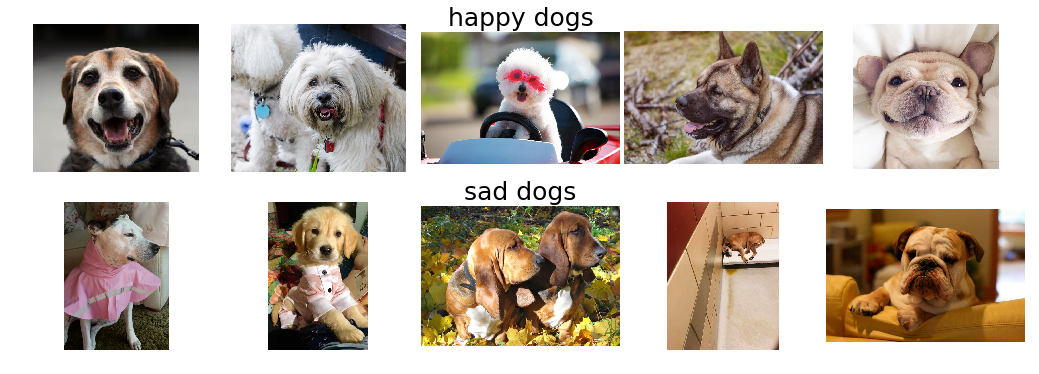

In [8]:
np.random.seed(seed=20)
n_samples = 5
fig, row = plt.subplots(2, n_samples, figsize = (4*n_samples, 3*2))

for col,folder in zip(row,data_folders):
    col[int(np.floor(n_samples/2))].set_title(folder,fontsize=25)
    working_dir = os.path.join(data_path,folder)
    os.chdir(working_dir)
    for col_ax,img in zip(col,np.random.choice(os.listdir(os.getcwd()),n_samples,replace=False)):
        rand_img = cv2.imread(img)
        rand_img = cv2.cvtColor(rand_img,cv2.COLOR_BGR2RGB)
        col_ax.imshow(rand_img)
        col_ax.axis('off')
plt.subplots_adjust(left=0.2, wspace=0.02)
os.chdir(original_path)

## Load and pre-processing

In [9]:
%%time
img_rows = 224
img_cols = 224
img_list = []
label_list = []
labels = dict([('sad dogs',0),('happy dogs',1)])
for folder in data_folders:
    working_dir = os.path.join(data_path,folder)
    os.chdir(working_dir)
    current_list = os.listdir(os.getcwd())
    for img in current_list:
        img_in = cv2.imread(img)    
        img_in = cv2.cvtColor(img_in,cv2.COLOR_BGR2RGB)    
        img_in = cv2.resize(img_in,(img_rows,img_cols),cv2.INTER_AREA)
        img_list.append(img_in)
        label_list.append(labels[folder])
os.chdir(original_path)

Wall time: 18 s


### normalization

In [10]:
img_data = np.array(img_list).astype('float32')
img_label = np.array(label_list)
img_data /= np.max(img_data)

## Splitting

NEW ADD

In [11]:
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
X_shuffled, y_shuffled = shuffle(img_data,img_label,random_state=0)

X_train,X_test,y_train,y_test = train_test_split(X_shuffled,y_shuffled,test_size=0.15,random_state=0,stratify=y_shuffled)
print('X_train shape: {}'.format(X_train.shape))
print('y_train shape: {}'.format(y_train.shape))
print('X_test shape: {}'.format(X_test.shape))
print('y_test shape: {}'.format(y_test.shape))

X_train shape: (1173, 224, 224, 3)
y_train shape: (1173,)
X_test shape: (208, 224, 224, 3)
y_test shape: (208,)


## Model building

### directory to save best models

In [12]:
os.mkdir('best_models_v2')

### import modules and params

In [13]:
from keras import initializers
from keras.models import Model,Sequential
from keras.layers import Input,Dense,Activation,BatchNormalization,Flatten,Conv2D,MaxPooling2D,GlobalAveragePooling2D,Dropout,Add
from keras.callbacks import ModelCheckpoint,ReduceLROnPlateau
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.models import load_model

Using TensorFlow backend.


In [14]:
%load_ext autoreload
%autoreload 2
import helper_module as hm

### Hyperparam search with Model #1: arbitrary CNN - initial trial (~ResNet) with Data augmentation
As an initial model, a simple resnet-like model was built. As the available dataset is small, it is augmented using `ImageDataGenerator`.

In [15]:
def identity_block(n_f,x):
    shortcut = x
    x = Conv2D(n_f,(3,3),strides=(1,1),padding='same',kernel_initializer='he_normal',activation='relu')(x)
    x = BatchNormalization()(x)
    x = Conv2D(n_f,(3,3),strides=(1,1),padding='same',kernel_initializer='he_normal')(x)
    x = BatchNormalization()(x)
    x = Add()([shortcut,x])
    x = Activation('relu')(x)
    return x

def conv_block(n_f,x):
    x = Conv2D(n_f,(3,3),strides=(2,2),padding='same',kernel_initializer='he_normal',activation='relu')(x)
    x = BatchNormalization()(x)
    x = Conv2D(n_f,(3,3),strides=(2,2),padding='same',kernel_initializer='he_normal',activation='relu')(x)
    x = BatchNormalization()(x)
    return x

In [16]:
from keras.preprocessing.image import ImageDataGenerator
datagen = ImageDataGenerator(width_shift_range=0.2,
                             height_shift_range=0.2,
                             horizontal_flip=True,
                             rotation_range=45)

In [17]:
inputs = Input(shape=img_data[0].shape)

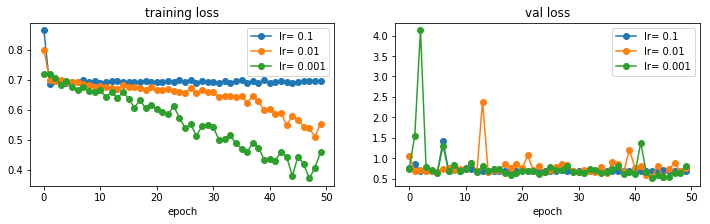

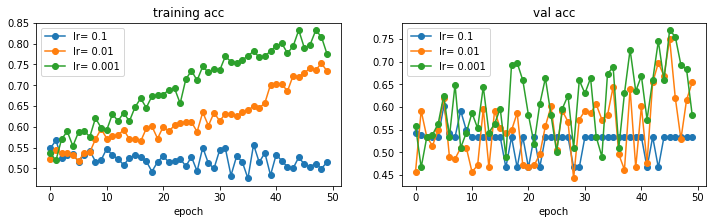

In [18]:
epochs = 50
batch_size = 16
lr_search = [0.1,0.01,0.001]

fig_loss, axes_loss = plt.subplots(1,2,figsize = (12,3))
fig_acc, axes_acc = plt.subplots(1,2,figsize = (12,3))
for lr_trial in lr_search:
    optimizer = Adam(lr=lr_trial, beta_1=0.9, beta_2=0.999, epsilon=10**-8)

    x = Conv2D(32,(3,3),strides=(2,2),padding='same',activation='relu')(inputs)
    x = MaxPooling2D(pool_size=(3,3),strides=(2,2),padding='same')(x)

    for _ in range(3):
        x = identity_block(32,x)
    x = conv_block(64,x)
    for _ in range(3):
        x = identity_block(64,x)

    x = GlobalAveragePooling2D()(x)
    outputs = Dense(1,activation='sigmoid')(x)
    model = Model(inputs,outputs)
    model.compile(optimizer=optimizer,loss='binary_crossentropy',metrics=['accuracy'])
    hist = model.fit_generator(datagen.flow(X_train,y_train,batch_size=batch_size),
                               steps_per_epoch = len(X_train)//batch_size,
                               epochs=epochs,
                               verbose=0,
                               validation_data=(X_test,y_test))
    loss = np.array([hist.history['loss'],hist.history['val_loss']])
    acc = np.array([hist.history['acc'],hist.history['val_acc']])

    for ax,los,name in zip(axes_loss,(loss[0],loss[1]),['training loss','val loss']):
        ax.plot(los,marker='o',label='lr= '+str(lr_trial))
        ax.legend(loc='best')
        ax.set_xlabel('epoch')
        ax.set_ylabel('')
        ax.set_title(name)
    for ax,los,name in zip(axes_acc,(acc[0],acc[1]),['training acc','val acc']):
        ax.plot(los,marker='o',label='lr= '+str(lr_trial))
        ax.legend(loc='best')
        ax.set_xlabel('epoch')
        ax.set_ylabel('')
        ax.set_title(name)

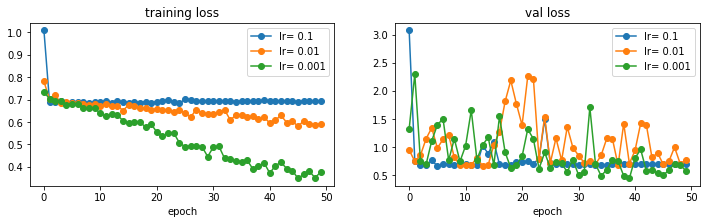

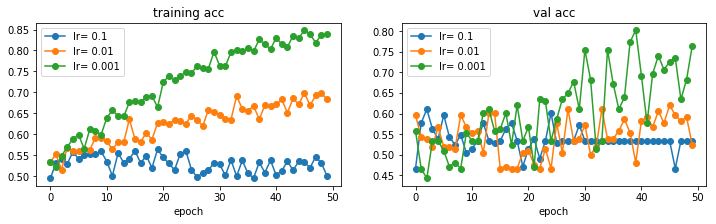

In [19]:
epochs = 50
batch_size = 32
lr_search = [0.1,0.01,0.001]

fig_loss, axes_loss = plt.subplots(1,2,figsize = (12,3))
fig_acc, axes_acc = plt.subplots(1,2,figsize = (12,3))
for lr_trial in lr_search:
    optimizer = Adam(lr=lr_trial, beta_1=0.9, beta_2=0.999, epsilon=10**-8)

    x = Conv2D(32,(3,3),strides=(2,2),padding='same',activation='relu')(inputs)
    x = MaxPooling2D(pool_size=(3,3),strides=(2,2),padding='same')(x)

    for _ in range(3):
        x = identity_block(32,x)
    x = conv_block(64,x)
    for _ in range(3):
        x = identity_block(64,x)

    x = GlobalAveragePooling2D()(x)
    outputs = Dense(1,activation='sigmoid')(x)
    model = Model(inputs,outputs)
    model.compile(optimizer=optimizer,loss='binary_crossentropy',metrics=['accuracy'])
    hist = model.fit_generator(datagen.flow(X_train,y_train,batch_size=batch_size),
                               steps_per_epoch = len(X_train)//batch_size,
                               epochs=epochs,
                               verbose=0,
                               validation_data=(X_test,y_test))
    loss = np.array([hist.history['loss'],hist.history['val_loss']])
    acc = np.array([hist.history['acc'],hist.history['val_acc']])

    for ax,los,name in zip(axes_loss,(loss[0],loss[1]),['training loss','val loss']):
        ax.plot(los,marker='o',label='lr= '+str(lr_trial))
        ax.legend(loc='best')
        ax.set_xlabel('epoch')
        ax.set_ylabel('')
        ax.set_title(name)
    for ax,los,name in zip(axes_acc,(acc[0],acc[1]),['training acc','val acc']):
        ax.plot(los,marker='o',label='lr= '+str(lr_trial))
        ax.legend(loc='best')
        ax.set_xlabel('epoch')
        ax.set_ylabel('')
        ax.set_title(name)

In [20]:
epochs = 200
batch_size = 32
learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss',patience=10,verbose=1,factor=0.75,min_lr=0.00001)

In [25]:
model_name = 'Model_1'
optimizer = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=10**-8)

x = Conv2D(32,(3,3),strides=(2,2),padding='same',activation='relu')(inputs)
x = MaxPooling2D(pool_size=(3,3),strides=(2,2),padding='same')(x)

for _ in range(3):
    x = identity_block(32,x)
x = Dropout(0.5)(x)
x = conv_block(64,x)
x = Dropout(0.5)(x)
for _ in range(3):
    x = identity_block(64,x)
x = Dropout(0.5)(x)
    
x = GlobalAveragePooling2D()(x)
outputs = Dense(1,activation='sigmoid')(x)
model_1 = Model(inputs,outputs)

model_1.compile(optimizer=optimizer,loss='binary_crossentropy',metrics=['accuracy'])
print(model_name)
hm.print_train_num_param(model_1)

Model_1
Trainable params: 334,849


In [26]:
best_model_path = os.path.join('best_models_v2','best-wiehgts-'+model_name+'-{epoch:03d}-{val_loss:.3f}-{val_acc:.3f}.hdf5')
save_best_model = ModelCheckpoint(best_model_path, monitor='val_loss', verbose=0, save_best_only=True, mode='min')
hist_1 = model_1.fit_generator(datagen.flow(X_train,y_train,batch_size=batch_size),
                                           steps_per_epoch = len(X_train)//batch_size,
                                           epochs=epochs,
                                           verbose=1,
                                           validation_data=(X_test,y_test),
                                           callbacks=[save_best_model,learning_rate_reduction])
model_1.save(os.path.join('best_models_v2',model_name+'-'+str(epochs)+'.hdf5'))

Epoch 1/200
36/36 [==============================] - 9s 259ms/step - loss: 0.7005 - acc: 0.5443 - val_loss: 0.8015 - val_acc: 0.4808
Epoch 2/200
36/36 [==============================] - 7s 182ms/step - loss: 0.6825 - acc: 0.5736 - val_loss: 0.7572 - val_acc: 0.5529
Epoch 3/200
36/36 [==============================] - 9s 257ms/step - loss: 0.6911 - acc: 0.5645 - val_loss: 0.9409 - val_acc: 0.4904
Epoch 4/200
36/36 [==============================] - 9s 255ms/step - loss: 0.6858 - acc: 0.5697 - val_loss: 1.0369 - val_acc: 0.5721
Epoch 5/200
36/36 [==============================] - 9s 253ms/step - loss: 0.6879 - acc: 0.5801 - val_loss: 1.1950 - val_acc: 0.5337
Epoch 6/200
36/36 [==============================] - 9s 243ms/step - loss: 0.6846 - acc: 0.5780 - val_loss: 0.8124 - val_acc: 0.4712
Epoch 7/200
36/36 [==============================] - 9s 240ms/step - loss: 0.6791 - acc: 0.5905 - val_loss: 0.7153 - val_acc: 0.5048
Epoch 8/200
36/36 [==============================] - 9s 237ms/step - 

36/36 [==============================] - 9s 248ms/step - loss: 0.3509 - acc: 0.8532 - val_loss: 0.7277 - val_acc: 0.7404

Epoch 00062: ReduceLROnPlateau reducing learning rate to 0.0007500000356230885.
Epoch 63/200
36/36 [==============================] - 8s 233ms/step - loss: 0.3634 - acc: 0.8476 - val_loss: 0.5090 - val_acc: 0.7788
Epoch 64/200
36/36 [==============================] - 9s 239ms/step - loss: 0.3292 - acc: 0.8641 - val_loss: 0.4661 - val_acc: 0.7596
Epoch 65/200
36/36 [==============================] - 9s 245ms/step - loss: 0.3256 - acc: 0.8619 - val_loss: 0.5577 - val_acc: 0.7548
Epoch 66/200
36/36 [==============================] - 9s 242ms/step - loss: 0.3339 - acc: 0.8480 - val_loss: 0.4704 - val_acc: 0.7837
Epoch 67/200
36/36 [==============================] - 9s 240ms/step - loss: 0.3213 - acc: 0.8580 - val_loss: 0.4377 - val_acc: 0.8029
Epoch 68/200
36/36 [==============================] - 9s 241ms/step - loss: 0.3259 - acc: 0.8506 - val_loss: 0.4228 - val_acc: 0

36/36 [==============================] - 9s 241ms/step - loss: 0.1827 - acc: 0.9284 - val_loss: 0.4763 - val_acc: 0.8221
Epoch 122/200
36/36 [==============================] - 9s 242ms/step - loss: 0.1752 - acc: 0.9240 - val_loss: 0.4691 - val_acc: 0.8269
Epoch 123/200
36/36 [==============================] - 9s 246ms/step - loss: 0.1642 - acc: 0.9366 - val_loss: 0.4733 - val_acc: 0.8221
Epoch 124/200
36/36 [==============================] - 9s 241ms/step - loss: 0.2031 - acc: 0.9140 - val_loss: 0.4128 - val_acc: 0.8413
Epoch 125/200
36/36 [==============================] - 9s 244ms/step - loss: 0.1604 - acc: 0.9327 - val_loss: 0.4632 - val_acc: 0.8462
Epoch 126/200
36/36 [==============================] - 9s 244ms/step - loss: 0.1667 - acc: 0.9436 - val_loss: 0.6453 - val_acc: 0.7788
Epoch 127/200
36/36 [==============================] - 9s 249ms/step - loss: 0.1814 - acc: 0.9331 - val_loss: 0.5001 - val_acc: 0.8269
Epoch 128/200
36/36 [==============================] - 9s 246ms/step 

Epoch 180/200
36/36 [==============================] - 9s 241ms/step - loss: 0.0916 - acc: 0.9687 - val_loss: 0.5461 - val_acc: 0.8317
Epoch 181/200
36/36 [==============================] - 9s 241ms/step - loss: 0.0976 - acc: 0.9661 - val_loss: 0.5549 - val_acc: 0.8125
Epoch 182/200
36/36 [==============================] - 9s 241ms/step - loss: 0.1047 - acc: 0.9635 - val_loss: 0.5873 - val_acc: 0.8221
Epoch 183/200
36/36 [==============================] - 9s 241ms/step - loss: 0.1000 - acc: 0.9657 - val_loss: 0.5379 - val_acc: 0.8317
Epoch 184/200
36/36 [==============================] - 9s 241ms/step - loss: 0.1005 - acc: 0.9614 - val_loss: 0.5123 - val_acc: 0.8221
Epoch 185/200
36/36 [==============================] - 9s 241ms/step - loss: 0.0924 - acc: 0.9609 - val_loss: 0.5346 - val_acc: 0.8173
Epoch 186/200
36/36 [==============================] - 9s 244ms/step - loss: 0.1066 - acc: 0.9592 - val_loss: 0.5982 - val_acc: 0.8221
Epoch 187/200
36/36 [==============================] - 

208/208 [==============================] - 0s 1ms/step
Test: accuracy = 0.826923  ;  loss = 0.547216


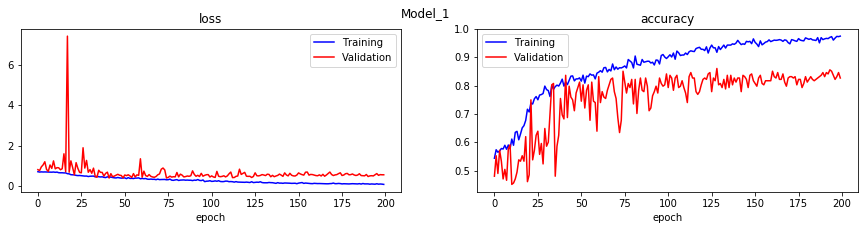

In [30]:
test_loss,test_accuracy = model_1.evaluate(X_test, y_test)
print("Test: accuracy = %f  ;  loss = %f" % (test_accuracy, test_loss))
hm.training_plot(hist_1,model_name)

In [31]:
chosen_model = load_model(os.path.join('best_models_v2','best-wiehgts-Model_1-075-0.388-0.851.hdf5'))
print('Choosing the model via early stopping')
test_loss,test_accuracy = chosen_model.evaluate(X_test, y_test)
print("Test: accuracy = %f  ;  loss = %f" % (test_accuracy, test_loss))

Choosing the model via early stopping
208/208 [==============================] - 1s 3ms/step
Test: accuracy = 0.850962  ;  loss = 0.387738


### Model #2: improving model #1 with dropout - handling overfitting

In [39]:
model_name = 'Model_2'
optimizer = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=10**-8)

x = Conv2D(32,(3,3),strides=(2,2),padding='same',activation='relu')(inputs)
x = MaxPooling2D(pool_size=(3,3),strides=(2,2),padding='same')(x)

for _ in range(3):
    x = identity_block(32,x)
x = Dropout(0.5)(x)
x = conv_block(64,x)
x = Dropout(0.5)(x)
for _ in range(3):
    x = identity_block(64,x)
x = Dropout(0.5)(x)
    
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)
outputs = Dense(1,activation='sigmoid')(x)

model_2 = Model(inputs,outputs)

model_2.compile(optimizer=optimizer,loss='binary_crossentropy',metrics=['accuracy'])
print(model_name)
hm.print_train_num_param(model_2)

Model_2
Trainable params: 334,849


In [40]:
best_model_path = os.path.join('best_models_v2','best-wiehgts-'+model_name+'-{epoch:03d}-{val_loss:.3f}-{val_acc:.3f}.hdf5')
save_best_model = ModelCheckpoint(best_model_path, monitor='val_loss', verbose=0, save_best_only=True, mode='min')
hist_2 = model_2.fit_generator(datagen.flow(X_train,y_train,batch_size=batch_size),
                                           steps_per_epoch = len(X_train)//batch_size,
                                           epochs=epochs,
                                           verbose=1,
                                           validation_data=(X_test,y_test),
                                           callbacks=[save_best_model,learning_rate_reduction])
model_2.save(os.path.join('best_models_v2',model_name+'-'+str(epochs)+'.hdf5'))

Epoch 1/200
36/36 [==============================] - 10s 288ms/step - loss: 1.0288 - acc: 0.5009 - val_loss: 1.2920 - val_acc: 0.5385
Epoch 2/200
36/36 [==============================] - 7s 186ms/step - loss: 0.8813 - acc: 0.5306 - val_loss: 2.8553 - val_acc: 0.4663
Epoch 3/200
36/36 [==============================] - 9s 249ms/step - loss: 0.7785 - acc: 0.5575 - val_loss: 0.6860 - val_acc: 0.6010
Epoch 4/200
36/36 [==============================] - 9s 249ms/step - loss: 0.7508 - acc: 0.5466 - val_loss: 0.7226 - val_acc: 0.5240
Epoch 5/200
36/36 [==============================] - 9s 249ms/step - loss: 0.7367 - acc: 0.5670 - val_loss: 0.8444 - val_acc: 0.4663
Epoch 6/200
36/36 [==============================] - 9s 244ms/step - loss: 0.7022 - acc: 0.5484 - val_loss: 0.7720 - val_acc: 0.4904
Epoch 7/200
36/36 [==============================] - 9s 242ms/step - loss: 0.6959 - acc: 0.5766 - val_loss: 1.9307 - val_acc: 0.4663
Epoch 8/200
36/36 [==============================] - 9s 242ms/step -

36/36 [==============================] - 9s 242ms/step - loss: 0.3677 - acc: 0.8406 - val_loss: 0.6267 - val_acc: 0.6971
Epoch 62/200
36/36 [==============================] - 9s 243ms/step - loss: 0.3705 - acc: 0.8407 - val_loss: 0.8830 - val_acc: 0.6394
Epoch 63/200
36/36 [==============================] - 9s 243ms/step - loss: 0.3733 - acc: 0.8276 - val_loss: 0.5587 - val_acc: 0.7308
Epoch 64/200
36/36 [==============================] - 9s 242ms/step - loss: 0.3597 - acc: 0.8367 - val_loss: 0.5768 - val_acc: 0.7067
Epoch 65/200
36/36 [==============================] - 9s 242ms/step - loss: 0.3876 - acc: 0.8228 - val_loss: 0.4823 - val_acc: 0.7548
Epoch 66/200
36/36 [==============================] - 9s 242ms/step - loss: 0.3819 - acc: 0.8328 - val_loss: 0.6610 - val_acc: 0.6442
Epoch 67/200
36/36 [==============================] - 9s 243ms/step - loss: 0.3517 - acc: 0.8541 - val_loss: 0.5202 - val_acc: 0.7596
Epoch 68/200
36/36 [==============================] - 9s 243ms/step - loss:

36/36 [==============================] - 9s 242ms/step - loss: 0.2205 - acc: 0.9084 - val_loss: 0.4853 - val_acc: 0.8125
Epoch 122/200
36/36 [==============================] - 9s 243ms/step - loss: 0.2378 - acc: 0.8936 - val_loss: 0.7807 - val_acc: 0.7260
Epoch 123/200
36/36 [==============================] - 9s 243ms/step - loss: 0.2148 - acc: 0.9136 - val_loss: 0.7776 - val_acc: 0.7500
Epoch 124/200
36/36 [==============================] - 9s 242ms/step - loss: 0.2169 - acc: 0.9132 - val_loss: 0.4952 - val_acc: 0.8365
Epoch 125/200
36/36 [==============================] - 9s 242ms/step - loss: 0.2270 - acc: 0.9045 - val_loss: 0.5814 - val_acc: 0.8029
Epoch 126/200
36/36 [==============================] - 9s 242ms/step - loss: 0.2133 - acc: 0.9214 - val_loss: 0.4648 - val_acc: 0.8173
Epoch 127/200
36/36 [==============================] - 9s 242ms/step - loss: 0.2575 - acc: 0.8914 - val_loss: 0.6668 - val_acc: 0.7933
Epoch 128/200
36/36 [==============================] - 9s 243ms/step 

36/36 [==============================] - 9s 242ms/step - loss: 0.1285 - acc: 0.9488 - val_loss: 0.4874 - val_acc: 0.8317

Epoch 00180: ReduceLROnPlateau reducing learning rate to 0.00023730468819849193.
Epoch 181/200
36/36 [==============================] - 9s 241ms/step - loss: 0.1356 - acc: 0.9470 - val_loss: 0.6312 - val_acc: 0.8029
Epoch 182/200
36/36 [==============================] - 9s 242ms/step - loss: 0.1092 - acc: 0.9627 - val_loss: 0.7282 - val_acc: 0.7740
Epoch 183/200
36/36 [==============================] - 9s 246ms/step - loss: 0.1078 - acc: 0.9540 - val_loss: 0.6509 - val_acc: 0.8125
Epoch 184/200
36/36 [==============================] - 9s 246ms/step - loss: 0.1232 - acc: 0.9483 - val_loss: 0.5854 - val_acc: 0.8173
Epoch 185/200
36/36 [==============================] - 9s 242ms/step - loss: 0.1003 - acc: 0.9622 - val_loss: 0.7080 - val_acc: 0.8173
Epoch 186/200
36/36 [==============================] - 9s 245ms/step - loss: 0.1035 - acc: 0.9661 - val_loss: 0.9255 - val

208/208 [==============================] - 0s 983us/step
Test: accuracy = 0.764423  ;  loss = 1.180260


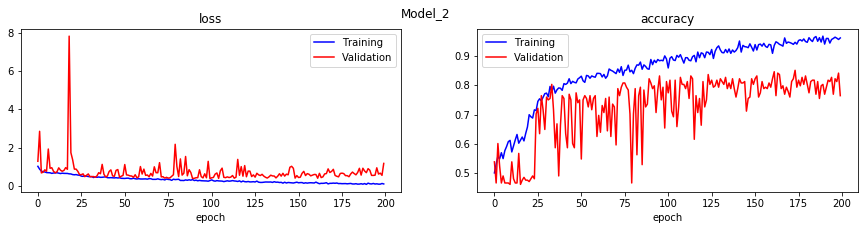

In [41]:
test_loss,test_accuracy = model_2.evaluate(X_test, y_test)
print("Test: accuracy = %f  ;  loss = %f" % (test_accuracy, test_loss))
hm.training_plot(hist_2,model_name)

In [42]:
chosen_model = load_model(os.path.join('best_models_v2','best-wiehgts-Model_2-100-0.393-0.812.hdf5'))
print('Choosing the model via early stopping')
test_loss,test_accuracy = chosen_model.evaluate(X_test, y_test)
print("Test: accuracy = %f  ;  loss = %f" % (test_accuracy, test_loss))

Choosing the model via early stopping
208/208 [==============================] - 1s 5ms/step
Test: accuracy = 0.812500  ;  loss = 0.392798


things to try
* modify model_1 2 blocks instead of 3 residual block?
* test 0.0001 for search
* change factor = 0.5

# START FROM HERE 

### Model #3: Transfer learnin gon ResNet50

In [27]:
img_rows = 224
img_cols = 224
img_list = []
label_list = []
labels = dict([('sad dogs',0),('happy dogs',1)])
for folder in data_folders:
    working_dir = os.path.join(data_path,folder)
    os.chdir(working_dir)
    current_list = os.listdir(os.getcwd())
    for img in current_list:
        img_in = cv2.imread(img)    
        img_in = cv2.cvtColor(img_in,cv2.COLOR_BGR2RGB)    
        img_in = cv2.resize(img_in,(img_rows,img_cols))
        img_list.append(img_in)
        label_list.append(labels[folder])
os.chdir(original_path)

img_data = np.array(img_list).astype('float32') ## without resizing
img_label = np.array(label_list)

X_shuffled, y_shuffled = shuffle(img_data,img_label,random_state=0)

X_train,X_valid_test,y_train,y_valid_test = train_test_split(X_shuffled,y_shuffled,test_size=0.1,random_state=0,stratify=y_shuffled)
X_valid,X_test,y_valid,y_test = train_test_split(X_valid_test,y_valid_test,test_size=0.5,random_state=0,stratify=y_valid_test)
print('X_train shape: {}'.format(X_train.shape))
print('y_train shape: {}'.format(y_train.shape))
print('X_valid shape: {}'.format(X_valid.shape))
print('y_valid shape: {}'.format(y_valid.shape))
print('X_test shape: {}'.format(X_test.shape))
print('y_test shape: {}'.format(y_test.shape))

X_train shape: (1256, 224, 224, 3)
y_train shape: (1256,)
X_valid shape: (70, 224, 224, 3)
y_valid shape: (70,)
X_test shape: (70, 224, 224, 3)
y_test shape: (70,)


In [28]:
from keras.applications.resnet50 import ResNet50,preprocess_input

In [29]:
datagen = ImageDataGenerator(width_shift_range=0.2,
                             height_shift_range=0.2,
                             horizontal_flip=True,
                             rotation_range=45,
                             preprocessing_function=preprocess_input)
                             
datagen.fit(X_train)

model_name = 'Model_3'
optimizer = Adam(lr=0.0005, beta_1=0.9, beta_2=0.999, epsilon=10**-8)
model_3_bottom = ResNet50(include_top=False, weights='imagenet')
last_layer = model_3_bottom.output
x = GlobalAveragePooling2D()(last_layer) #175th layer
# x = Dense(128)(x)
# x = BatchNormalization()(x)
# x = Activation('relu')(x)
# x = Dropout(0.5)(x)
outputs = Dense(1, activation='sigmoid')(x)
model_3 = Model(model_3_bottom.input,outputs)

print(model_name+' before freezing')
hm.print_train_num_param(model_3)
for layer in model_3.layers[:175]:
    layer.trainable=False
print(model_name+' after freezing')
hm.print_train_num_param(model_3)

C:\Users\sungsooc\AppData\Local\Continuum\anaconda3\envs\workspace-gpu-custom-keras\lib\site-packages\keras_applications\resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


Model_3 before freezing
Trainable params: 23,536,641
Model_3 after freezing
Trainable params: 2,049


In [30]:
model_3.compile(optimizer=optimizer,loss='binary_crossentropy',metrics=['accuracy'])
best_model_path = os.path.join('best_models','best-wiehgts-'+model_name+'-{epoch:03d}-{val_loss:.3f}-{val_acc:.3f}.hdf5')
save_best_model = ModelCheckpoint(best_model_path, monitor='val_loss', verbose=0, save_best_only=True, mode='min')
hist_3 = model_3.fit_generator(datagen.flow(X_train,y_train,batch_size=batch_size),
                                           steps_per_epoch = len(X_train)//batch_size,
                                           epochs=epochs,
                                           verbose=0,
                                           validation_data=(X_valid,y_valid),
                                           callbacks=[save_best_model,learning_rate_reduction])


Epoch 00032: ReduceLROnPlateau reducing learning rate to 0.00035000001662410796.

Epoch 00042: ReduceLROnPlateau reducing learning rate to 0.00024500001163687554.

Epoch 00052: ReduceLROnPlateau reducing learning rate to 0.00017150000203400848.

Epoch 00062: ReduceLROnPlateau reducing learning rate to 0.00012004999734926967.

Epoch 00072: ReduceLROnPlateau reducing learning rate to 8.403499814448878e-05.

Epoch 00082: ReduceLROnPlateau reducing learning rate to 5.882449768250808e-05.

Epoch 00092: ReduceLROnPlateau reducing learning rate to 4.117714888707269e-05.

Epoch 00102: ReduceLROnPlateau reducing learning rate to 2.88240029476583e-05.

Epoch 00112: ReduceLROnPlateau reducing learning rate to 2.0176801808702293e-05.

Epoch 00122: ReduceLROnPlateau reducing learning rate to 1.4123761138762347e-05.

Epoch 00132: ReduceLROnPlateau reducing learning rate to 1e-05.


70/70 [==============================] - 0s 6ms/step
Valid: accuracy = 0.785714  ;  loss = 0.549115
Test: accuracy = 0.757143  ;  loss = 0.615957


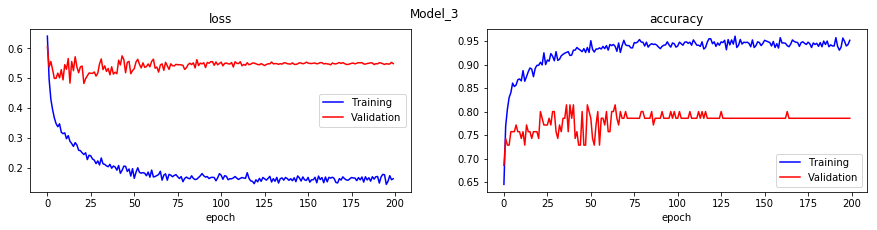

In [31]:
hm.print_valid_test_score(model_3,X_valid,y_valid,X_test,y_test)
hm.training_plot(hist_3,model_name) 

In [32]:
chosen_model = load_model(os.path.join('best_models','best-wiehgts-Model_3-022-0.483-0.800.hdf5'))
print('Choosing the model via early stopping')
hm.print_valid_test_score(chosen_model,X_valid,y_valid,X_test,y_test)

Choosing the model via early stopping
70/70 [==============================] - 0s 6ms/step
Valid: accuracy = 0.800000  ;  loss = 0.482709
Test: accuracy = 0.771429  ;  loss = 0.562989


## Testing new image of Lucky!

#### For best custom model

In [33]:
img_rows = 224
img_cols = 224

In [32]:
chosen_model = model_1

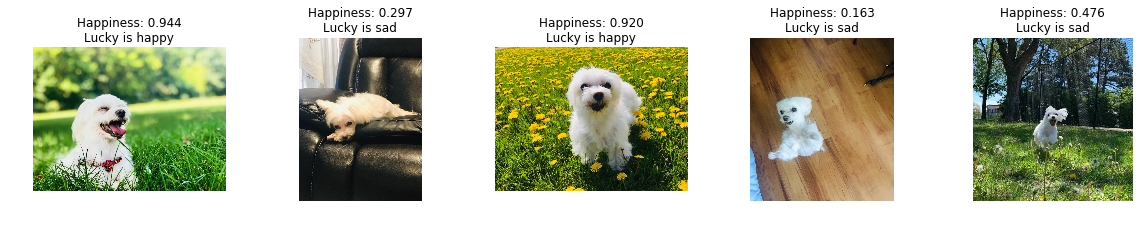

In [33]:
fig, axes = plt.subplots(1, 5, figsize = (4*5, 3*1))
for ax,img_num in zip(axes,range(1,6)):
    img = cv2.imread(os.path.join('test_images','Lucky_'+str(img_num)+'.jpg'))
    img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    ax.imshow(img)
    
    img = cv2.resize(img,(img_rows,img_cols)).astype('float32')
    img /= 255
    img = np.expand_dims(img,axis=0)
    ax.axis('off')
    predict_rate = chosen_model.predict(img)[0][0]
    if predict_rate >= 0.5:
        predict_class = 'happy'
    else: predict_class = 'sad'
    ax.set_title('Happiness: {:.3f}\nLucky is {}'.format(predict_rate,predict_class))


#### For best transfer-learned model

In [11]:
chosen_model= load_model(os.path.join('best_models','best-wiehgts-Model_3-022-0.483-0.800.hdf5'))

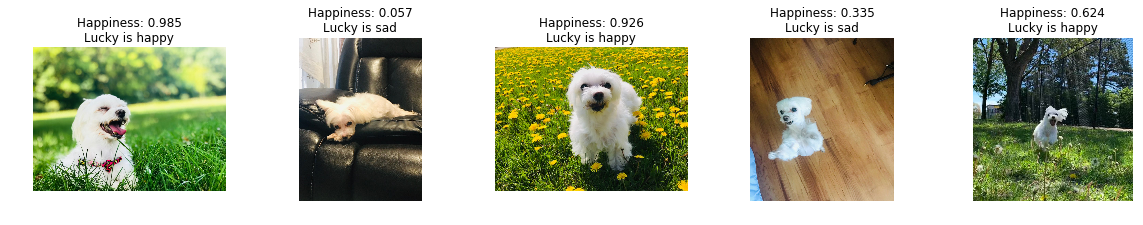

In [12]:
fig, axes = plt.subplots(1, 5, figsize = (4*5, 3*1))
for ax,img_num in zip(axes,range(1,6)):
    img = cv2.imread(os.path.join('test_images','Lucky_'+str(img_num)+'.jpg'))
    img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    ax.imshow(img)
    
    img = cv2.resize(img,(img_rows,img_cols)).astype('float32')
    img = preprocess_input(img)
    img = np.expand_dims(img,axis=0)
    ax.axis('off')
    predict_rate = chosen_model.predict(img)[0][0]
    if predict_rate >= 0.5:
        predict_class = 'happy'
    else: predict_class = 'sad'
    ax.set_title('Happiness: {:.3f}\nLucky is {}'.format(predict_rate,predict_class))

## To do..
* show mislabeled examples
* make the notebook using image generator
* articles about using flow and flow_from_directory